In [1]:
import spikeinterface.full as si
import probeinterface as pif
import numpy as np
from probeinterface.plotting import plot_probe
import matplotlib.pyplot as plt
import scipy.io as scio
import os
import json
import paramiko
import subprocess
import re
from scp import SCPClient

In [2]:
%matplotlib widget

# Ideally you want to run Catgt at this point, if you haven't already
```
C:\CatGT-win/CatGT.exe -dir=D:\NPX_Data\M465\sourcedata\sub-M465 -run=M465-2024-01-31 -g=0 -t=0 -prb_fld -t_miss_ok -ni -ap -prb=0 -dest=D:\NPX_Data\M465\custom_preprocessed\M465-2024-01-31
```
For a 2 probe session, the command changes slightly
```
C:\CatGT-win/CatGT.exe -dir=D:\NPX_Data\OdorPixels\Pilot1\M465\sourcedata\sub-M465 -run=M465-2024-02-02 -g=0 -t=0 -prb_fld -t_miss_ok -ni -ap -prb='0,1' -dest=D:\NPX_Data\OdorPixels\Pilot1\M465\preprocessed\M465-2024-02-02
```
- VERY IMPORTANT!! Do not apply global CAR to be able to use LFPs later
- Adding the option `-no_autosync` will not extract the sync file stamps from the nidq, or the imec streams
- Set the destination to a different folder, outside of the parent folder, because spikeinterface can't read when t0 and tcat files are inside the same folder. Optionally do not set the `-dest` parameter, and just delete the *g0_t0.imec.ap.bin
- The 'run' parameter must not include "g0"
- The destination folder must not exist, but the its parent folder must (In this case D:\NPX_data\M483 should exist, but **NOT** D:\NPX_data\M483\M483-2024-01-22_tcat)


In [3]:
# path to meta file
meta_filename = 'C:\\data\\nsb2024\\M564_2024_07_09_NP2_4_Shanks_Anahat_Mario_Test_01_g0\\M564_2024_07_09_NP2_4_Shanks_Anahat_Mario_Test_01_g0_t0.nidq.meta'
probe = pif.read_spikeglx(meta_filename)
fig,ax = plt.subplots()
plot_probe(probe, ax=ax)
ax.set_aspect(0.1) # Change depending on the probe
ax.set_ylim([-100, 5000]) # Change depending on the probe
ax.set_title('NPX 2') # Change depending on the probe


AssertionError: Could not find imroTbl field in meta file!

In [4]:
# Should point to the folder containing the tcat-ed .bin files
raw_rec = si.read_spikeglx('C:\\data\\nsb2024\\preprocessed\\catgt_M564_2024_07_09_NP2_4_Shanks_Anahat_Mario_Test_01_g0\\', stream_name='imec0.ap')

In [5]:
# raw_rec = si.phase_shift(raw_rec) # DO NOT APPLY phase_shift it tcat has already been applied
rec1 = si.highpass_filter(raw_rec, freq_min=400.)
bad_channel_ids, channel_labels = si.detect_bad_channels(rec1)
print('bad_channel_ids, channel_labels')
for bad_channel_id in bad_channel_ids:
    index = int(bad_channel_id.split('AP')[1])
    print('{}, {}'.format(bad_channel_id, channel_labels[index]))


bad_channel_ids, channel_labels


In [6]:
# Edit the bad_channel_ids array after cross-checking in SpiukeGLX viewer
new_array = bad_channel_ids
new_array = np.append(new_array, 'imec0.ap#AP100')
new_array

array(['imec0.ap#AP100'], dtype='<U64')

In [7]:
# Channels labeled 'out' make sense in this case, not sure about the one marked 'dead' -- removing in any case (Confirm by viewing in SpikeGLX viewer)
rec1  = rec1.remove_channels(bad_channel_ids)

### Setup Kilosort parameters 

In [7]:
ks2_path = 'C:\\Users\\mvdmlab\\Documents\\GitHub\\Kilosort-2.5' # Change according to the system you are using
si.Kilosort2_5Sorter.set_kilosort2_5_path(ks2_path)
si.Kilosort2_5Sorter.is_installed() # Must return true, if not change the path accordingly

Setting KILOSORT2_5_PATH environment variable for subprocess calls to: C:\Users\mvdmlab\Documents\GitHub\Kilosort-2.5


True

In [12]:
ks2_5_params = si.get_default_sorter_params('kilosort2_5')
ks2_5_params

{'detect_threshold': 6,
 'projection_threshold': [10, 4],
 'preclust_threshold': 8,
 'momentum': [20.0, 400.0],
 'car': True,
 'minFR': 0.1,
 'minfr_goodchannels': 0.1,
 'nblocks': 5,
 'sig': 20,
 'freq_min': 150,
 'sigmaMask': 30,
 'lam': 10.0,
 'nPCs': 3,
 'ntbuff': 64,
 'nfilt_factor': 4,
 'NT': None,
 'AUCsplit': 0.9,
 'do_correction': True,
 'wave_length': 61,
 'keep_good_only': False,
 'skip_kilosort_preprocessing': False,
 'scaleproc': None,
 'save_rez_to_mat': False,
 'delete_tmp_files': ('matlab_files',),
 'delete_recording_dat': False,
 'n_jobs': 16,
 'chunk_duration': '1s',
 'progress_bar': True,
 'mp_context': None,
 'max_threads_per_process': 1}

In [13]:
# Make any changes if needed to these params before dumping to json, example: ks2_params['detect_threshold'] = 4
ks2_5_params['delete_recording_dat'] = True
remote_params = {'bad_channels': bad_channel_ids.tolist(), 'ks2_5_params': ks2_5_params}

## Running Kilosort remotely

In [ ]:
# Save this where the catgt output folder is located
f = open('E:\\RR2_NPX\\M465\\M465-2024-01-31\\catgt_M465-2024-01-31_g0\\remote_params.json', 'w')
json.dump(remote_params, f, indent=4)
f.close()

In [ ]:
# Local Parameters
remote_script_filepath = 'E:\\RR2_NPX\\M465\\M465-2024-01-31\\catgt_M465-2024-01-31_g0\\remote_sort.py' # Where the remote_sort.py lives inside the catgt output folder
remote_params_filepath = 'E:\\RR2_NPX\\M465\\M465-2024-01-31\\catgt_M465-2024-01-31_g0\\remote_params.json' # Where remote_params.json lives
bin_filepath = 'E:\\RR2_NPX\\M465\\M465-2024-01-31\\catgt_M465-2024-01-31_g0\\M465-2024-01-31_g0_tcat.imec0.ap.bin' # Where the catgt-ed bin file lives
meta_filepath = 'E:\\RR2_NPX\\M465\\M465-2024-01-31\\catgt_M465-2024-01-31_g0\\M465-2024-01-31_g0_tcat.imec0.ap.meta' # Where the catgt-ed meta file lives
local_dest_path = 'E:\\RR2_NPX\\M465\\M465-2024-01-31\\' # Destination to copy stuff back to

In [ ]:
# SSH settings for the remote server with password-based authentication
remote_server = {
    'hostname': 'mvdmlab-deimos',
    'username': 'kleaman',
    'password': 'ozomatl1',
    'dest_path': '/home/kleaman/incoming_ks2',
    'conda_environment': 'spikeinterface',
}
# Connect to the remote server using password-based authentication
remote_client = paramiko.SSHClient()
remote_client.set_missing_host_key_policy(paramiko.AutoAddPolicy())

In [ ]:
# Transfer all the required files in one go
try:
    remote_client.connect(
        hostname=remote_server['hostname'],
        username=remote_server['username'],
        password=remote_server['password']
    )
    scp_client = SCPClient(remote_client.get_transport())
    # Transfer the params file
    scp_client.put(remote_script_filepath, remote_server['dest_path'], recursive=True)
    # Transfer the params file
    scp_client.put(remote_params_filepath, remote_server['dest_path'], recursive=True)
    # Transfer the params file
    scp_client.put(bin_filepath, remote_server['dest_path'], recursive=True)
    # Transfer the params file
    scp_client.put(meta_filepath, remote_server['dest_path'], recursive=True)
    print( "All files transferred")

except Exception as e:
    print(e)

finally:
    # Close the SSH connection to the remote server
    remote_client.close()

### Steps to run the script remotely
1. Open an Anaconda **POWERSHELL** Prompt
2. Type the following commands in order:
   ```
   ssh kleaman@mvdmlab-deimos


   cd incoming_ks2
   conda activate spikeinterface
   python remote_sort.py
```
3. Do Not Close that prompt -- wait until it finishes

In [ ]:
# # Remotely run kilosort
# try:
#     remote_client.connect(
#         hostname=remote_server['hostname'],
#         username=remote_server['username'],
#         password=remote_server['password']
#     )
#     command = f"cd incoming_ks2 && source remote_run.sh" #f"source ~/incoming_ks2/remote_run.sh" 
#     stdin, stdout, stderr = remote_client.exec_command(command)

#     print (stderr.read().decode('utf-8'))
#     # Wait for the command to finish executing
#     exit_status = stdout.channel.recv_exit_status()
    
#     if exit_status != 0:
#         print("Error running remote_sort.py on the remote server.")
#     else:
#         print("remote_sort.py on the remote server has finished executing.")
# finally:
#     # Close the SSH connection to the remote server
#     remote_client.close()

In [ ]:
# Get back the kilosort output from the remote computer
try:
    remote_client.connect(
        hostname=remote_server['hostname'],
        username=remote_server['username'],
        password=remote_server['password']
    )
    scp_client = SCPClient(remote_client.get_transport())
    # Transfer the params file
    scp_client.get('/ks2_t/ks2_5_output', local_dest_path, recursive=True)
    print( "All files transferred")

except Exception as e:
    print(e)

finally:
    # Close the SSH connection to the remote server
    remote_client.close()

### Steps after Kilosort output is back to the local computer
1. Change params.py to point to the './temp_wh.dat' instead of whatever weird looking thing you see
2. Using the powershell window that you used to login (if you closed it, login again), run the following commands:
   ```
   rm -rf ~/incoming_ks2/*

   rm -rf /ks2_t/*
   ```
3. You can close the window now :)

## Running Kilosort locally

In [10]:
# Kilosort needs a binary file and the code segment below achieves that (might take a while to run)

si_working_folder = 'E:\\Temp-M465' # Make sure this folder exists
job_kwargs = dict(n_jobs=40, chunk_duration='1s', progress_bar=True)
rec1 = rec1.save(folder=os.path.join(si_working_folder, 'si_preprocess'), format='binary', **job_kwargs)
this_rec = rec1

write_binary_recording with n_jobs = 40 and chunk_size = 30000


write_binary_recording:   0%|          | 0/1564 [00:00<?, ?it/s]

In [ ]:
# Run the below cell only if the jupyter notebook session was restarted after writing the binary file

# # The binary file written by si has certain details missing. These need to be filled up from rec1 (filtered and bad chanels removed)
# # for Kilosort to work properly
# si_working_folder = 'E:\\Temp\\si_preprocess' # Where the binary file is written by SpikeInterface is present
# this_rec  = si.read_binary(os.path.join(si_working_folder, 'traces_cached_seg0.raw'), sampling_frequency=rec1.get_sampling_frequency(), \
#                            dtype='int16', num_channels=rec1.get_num_channels())
# this_rec.annotate(is_filtered=rec1.is_filtered())
# for key in rec1.get_property_keys():
#     this_rec.set_property(key, rec1.get_property(key))
# this_rec.set_channel_gains(rec1.get_channel_gains())
# this_rec.set_probe(rec1.get_probe())
# this_rec.annotate(probes_info=rec1.get_annotation('probes_info'))
# this_rec.annotate(probe_0_planar_contour=rec1.get_annotation('probe_0_planar_contour'))

In [14]:
ks_working_folder = 'E:\\Temp-M465' # This should be the fastest SSD for best results 
sorting = si.run_sorter('kilosort2_5', this_rec, output_folder=os.path.join(ks_working_folder, 'ks2_output'),
                        verbose=True, remove_existing_folder=False, **ks2_5_params)

RUNNING SHELL SCRIPT: E:\Temp-M465\ks2_output\sorter_output\run_kilosort2_5.bat


C:\Users\mvdmlab\Documents\Manish\odor-pixels\pre-processing>E:



E:\>cd E:\Temp-M465\ks2_output\sorter_output 



E:\Temp-M465\ks2_output\sorter_output>matlab -nosplash -wait -r "kilosort2_5_master('E:\Temp-M465\ks2_output\sorter_output', 'C:\Users\mvdmlab\Documents\GitHub\Kilosort-2.5')" 

kilosort2_5 run time 1291.06s


##  Do manual sorting using phy

In [6]:
# The path should point to the folder that contains phy output
this_rec = rec1 # rec1 is the filtered recording, with the bad channels removed
sorting = si.KiloSortSortingExtractor(folder_path='E:\\Temp-M465\\ks2_output\sorter_output')
sorting

KiloSortSortingExtractor: 276 units - 1 segments - 30.0kHz

In [8]:
# Run the following cell **ONLY** if the notebook was restarted after manual curation

# # This has to match the the details from temp_wh.dat, which is the binary file written
# # by Kilosort. This has to be appended with the appropriate channel ids and channel_locations
# # using rec2 that has the bad channels removed
# this_rec  = si.read_binary('E:\\Temp-M465\\ks2_output\\sorter_output\\temp_wh.dat', sampling_frequency=rec1.get_sampling_frequency(), \
#                            dtype='int16', num_channels=rec1.get_num_channels())
# this_rec.annotate(is_filtered=rec1.is_filtered())
# for key in rec1.get_property_keys():
#     this_rec.set_property(key, rec1.get_property(key))
# this_rec.set_channel_gains(rec1.get_channel_gains())
# this_rec.set_probe(rec1.get_probe())
# this_rec.annotate(probes_info=rec1.get_annotation('probes_info'))
# this_rec.annotate(probe_0_planar_contour=rec1.get_annotation('probe_0_planar_contour'))
# sorting.register_recording(this_rec)

## Collating information about clean cells

In [9]:
# KSlabel is Kilosort label, quality is user annotated
keep_idx = np.where(sorting.get_property('quality') == 'good')[0] # np.wher returns a tuple, so the extra '[0]'
keep_units = sorting.unit_ids[keep_idx]

In [11]:
clean_units = sorting.select_units(keep_units)
clean_spike_train = [clean_units.get_unit_spike_train(x)/clean_units.get_sampling_frequency() \
    for x in clean_units.unit_ids]
clean_channel_ids = [str(x) for x in keep_units]
# If 2 probes are being used, prefix 'imec0_' and 'imec1_' to the respective channel_ids
clean_channel_ids = ['imec0_'+x for x in clean_channel_ids]
clean_depths = clean_units.get_property('depth')

### The below code is to extract the waveforms of the curated neurons

In [12]:
job_kwargs = dict(n_jobs=40, chunk_duration='1s', progress_bar=True)
# the folder mentioned below must not exist
curated_wv = si.extract_waveforms(this_rec, clean_units, "E:\\Temp-M465\\si_waveforms", **job_kwargs)
# The waveforms are in the shape max(500, nspikes), a variable number of  channels, timepoints
clean_waveforms = [np.mean(curated_wv.get_waveforms(x), axis=0).T for x in clean_units.unit_ids]

extract waveforms shared_memory multi buffer:   0%|          | 0/1564 [00:00<?, ?it/s]

extract waveforms memmap multi buffer:   0%|          | 0/1564 [00:00<?, ?it/s]

### Saving as mat-files

In [13]:
spikes_mat_fname = 'E:\\Temp-M465\\clean units_imec0.mat' # add imec0 or imec1 if 2 probes
scio.savemat(spikes_mat_fname, {'depths': clean_depths, 'channel_ids': clean_channel_ids, \
    'spike_train': clean_spike_train, 'clean_waveforms': clean_waveforms})

# TODO: Have a matlab script to load this into the ts format, 
# and the actual depths need to be calculated by subtracting from the recording depth

# Run the following if there is a second probe

Text(0.5, 1.0, 'NPX 1')

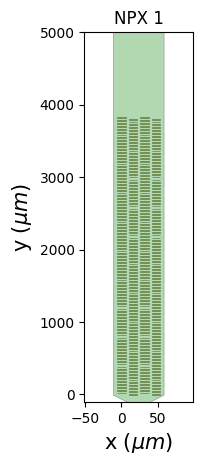

In [3]:
# path to meta file
meta_filename = 'D:\\NPX_Data\\OdorPixels\\Pilot1\\M465\\preprocessed\\M465-2024-02-02\\catgt_M465-2024-02-02_g0\\M465-2024-02-02_g0_tcat.imec1.ap.meta'
probe = pif.read_spikeglx(meta_filename)
fig,ax = plt.subplots()
plot_probe(probe, ax=ax)
ax.set_aspect(0.1) # Change depending on the probe
ax.set_ylim([-100, 5000]) # Change depending on the probe
ax.set_title('NPX 1') # Change depending on the probe

In [4]:
# Should point to the folder containing the tcat-ed .bin files
raw_rec2 = si.read_spikeglx('D:\\NPX_Data\\OdorPixels\\Pilot1\\M465\\preprocessed\\M465-2024-02-02\\catgt_M465-2024-02-02_g0', stream_name='imec1.ap')

In [5]:
# raw_rec2 = si.phase_shift(raw_rec2) # DO NOT APPLY phase_shift it tcat has already been applied
rec2 = si.highpass_filter(raw_rec2, freq_min=400.)
bad_channel_ids2, channel_labels2 = si.detect_bad_channels(rec2)
print('bad_channel_ids, channel_labels')
for bad_channel_id in bad_channel_ids2:
    index = int(bad_channel_id.split('AP')[1])
    print('{}, {}'.format(bad_channel_id, channel_labels2[index]))

bad_channel_ids, channel_labels
imec1.ap#AP191, dead


In [ ]:
# Edit the bad_channel_ids array after cross-checking in SpiukeGLX viewer
new_array = bad_channel_ids2
new_array = np.append(new_array, 'imec0.ap#AP100')
new_array

In [6]:
# Channels labeled 'out' make sense in this case, not sure about the one marked 'dead' -- removing in any case (Confirm by viewing in SpikeGLX viewer)
rec2  = rec2.remove_channels(bad_channel_ids2)

### Setup Kilosort parameters 

In [29]:
ks2_path = 'C:\\Users\\mvdmlab\\Documents\\GitHub\\Kilosort-2.5' # Change according to the system you are using
si.Kilosort2_5Sorter.set_kilosort2_5_path(ks2_path)
si.Kilosort2_5Sorter.is_installed() # Must return true, if not change the path accordingly

Setting KILOSORT2_5_PATH environment variable for subprocess calls to: C:\Users\mvdmlab\Documents\GitHub\Kilosort-2.5


True

In [30]:
ks2_5_params = si.get_default_sorter_params('kilosort2_5')
ks2_5_params

{'detect_threshold': 6,
 'projection_threshold': [10, 4],
 'preclust_threshold': 8,
 'momentum': [20.0, 400.0],
 'car': True,
 'minFR': 0.1,
 'minfr_goodchannels': 0.1,
 'nblocks': 5,
 'sig': 20,
 'freq_min': 150,
 'sigmaMask': 30,
 'lam': 10.0,
 'nPCs': 3,
 'ntbuff': 64,
 'nfilt_factor': 4,
 'NT': None,
 'AUCsplit': 0.9,
 'do_correction': True,
 'wave_length': 61,
 'keep_good_only': False,
 'skip_kilosort_preprocessing': False,
 'scaleproc': None,
 'save_rez_to_mat': False,
 'delete_tmp_files': ('matlab_files',),
 'delete_recording_dat': False,
 'n_jobs': 16,
 'chunk_duration': '1s',
 'progress_bar': True,
 'mp_context': None,
 'max_threads_per_process': 1}

In [31]:
# Make any changes if needed to these params before dumping to json, example: ks2_params['detect_threshold'] = 4
ks2_5_params['delete_recording_dat'] = True
remote_params = {'bad_channels': bad_channel_ids.tolist(), 'ks2_params': ks2_5_params}

## Running Kilosort remotely

In [ ]:
# Save this where the catgt output folder is located
f = open('E:\\RR2_NPX\\M465\\M465-2024-01-31\\catgt_M465-2024-01-31_g0\\remote_params.json', 'w')
json.dump(remote_params, f, indent=4)
f.close()

In [ ]:
# Local Parameters
remote_script_filepath = 'E:\\RR2_NPX\\M465\\M465-2024-02-01\\catgt_M465-2024-02-01_g0\\remote_sort.py' # Where the remote_sort.py lives inside the catgt output folder
remote_params_filepath = 'E:\\RR2_NPX\\M465\\M465-2024-02-01\\catgt_M465-2024-02-01_g0\\remote_params.json' # Where remote_params.json lives
bin_filepath = 'E:\\RR2_NPX\\M465\\M465-2024-02-01\\catgt_M465-2024-02-01_g0\\M465-2024-02-01_g0_tcat.imec1.ap.bin' # Where the catgt-ed bin file lives
meta_filepath = 'E:\\RR2_NPX\\M465\\M465-2024-02-01\\catgt_M465-2024-02-01_g0\\M465-2024-02-01_g0_tcat.imec1.ap.meta' # Where the catgt-ed meta file lives
local_dest_path = 'E:\\RR2_NPX\\M465\\M465-2024-02-01\\probe2\\' # Destination to copy stuff back to, might have to create this folder

In [ ]:
# SSH settings for the remote server with password-based authentication
remote_server = {
    'hostname': 'mvdmlab-deimos',
    'username': 'kleaman',
    'password': 'ozomatl1',
    'dest_path': '/home/kleaman/incoming_ks2',
    'conda_environment': 'spikeinterface',
}
# Connect to the remote server using password-based authentication
remote_client = paramiko.SSHClient()
remote_client.set_missing_host_key_policy(paramiko.AutoAddPolicy())

In [ ]:
# Transfer all the required files in one go
try:
    remote_client.connect(
        hostname=remote_server['hostname'],
        username=remote_server['username'],
        password=remote_server['password']
    )
    scp_client = SCPClient(remote_client.get_transport())
    # Transfer the params file
    scp_client.put(remote_script_filepath, remote_server['dest_path'], recursive=True)
    # Transfer the params file
    scp_client.put(remote_params_filepath, remote_server['dest_path'], recursive=True)
    # Transfer the params file
    scp_client.put(bin_filepath, remote_server['dest_path'], recursive=True)
    # Transfer the params file
    scp_client.put(meta_filepath, remote_server['dest_path'], recursive=True)
    print( "All files transferred")

except Exception as e:
    print(e)

finally:
    # Close the SSH connection to the remote server
    remote_client.close()

### Steps to run the script remotely
1. Open an Anaconda **POWERSHELL** Prompt
2. Type the following commands in order:
   ```
   ssh kleaman@mvdmlab-deimos


   cd incoming_ks2
   conda activate spikeinterface
   python remote_sort.py
```
3. Do Not Close that prompt -- wait until it finishes

In [ ]:
# # Remotely run kilosort
# try:
#     remote_client.connect(
#         hostname=remote_server['hostname'],
#         username=remote_server['username'],
#         password=remote_server['password']
#     )
#     command = f"cd incoming_ks2 && source remote_run.sh" #f"source ~/incoming_ks2/remote_run.sh" 
#     stdin, stdout, stderr = remote_client.exec_command(command)

#     print (stderr.read().decode('utf-8'))
#     # Wait for the command to finish executing
#     exit_status = stdout.channel.recv_exit_status()
    
#     if exit_status != 0:
#         print("Error running remote_sort.py on the remote server.")
#     else:
#         print("remote_sort.py on the remote server has finished executing.")
# finally:
#     # Close the SSH connection to the remote server
#     remote_client.close()

In [ ]:
# Get back the kilosort output from the remote computer
try:
    remote_client.connect(
        hostname=remote_server['hostname'],
        username=remote_server['username'],
        password=remote_server['password']
    )
    scp_client = SCPClient(remote_client.get_transport())
    # Transfer the params file
    scp_client.get('/ks2_t/ks2_5_output', local_dest_path, recursive=True)
    print( "All files transferred")

except Exception as e:
    print(e)

finally:
    # Close the SSH connection to the remote server
    remote_client.close()

### Steps after Kilosort output is back to the local computer
1. Change params.py to point to the './temp_wh.dat' instead of whatever weird looking thing you see
2. Using the powershell window that you used to login (if you closed it, login again), run the following commands:
   ```
   rm -rf ~/incoming_ks2/*

   rm -rf /ks2_t/*
   ```
3. You can close the window now :)
4. Some renaming and moving steps

## Running Kilosort locally

In [32]:
si_working_folder = 'E:\\Temp' # Make sure this folder exists
job_kwargs = dict(n_jobs=40, chunk_duration='1s', progress_bar=True)
rec2 = rec2.save(folder=os.path.join(si_working_folder, 'si_preprocess2'), format='binary', **job_kwargs)
this_rec2 = rec2

write_binary_recording with n_jobs = 40 and chunk_size = 30000


write_binary_recording:   0%|          | 0/1515 [00:00<?, ?it/s]

In [24]:
# Run the below cell only if the jupyter notebook session was restarted after writing the binary file

# The binary file written by si has certain details missing. These need to be filled up from rec1 (filtered and bad chanels removed)
# for Kilosort to work properly
# si_working_folder = 'E:\\Temp\\si_preprocess2' # Where the binary file is written by SpikeInterface is present
# this_rec2  = si.read_binary(os.path.join(si_working_folder, 'traces_cached_seg0.raw'), sampling_frequency=rec2.get_sampling_frequency(), \
#                            dtype='int16', num_channels=rec2.get_num_channels())
# this_rec2.annotate(is_filtered=rec2.is_filtered())
# for key in rec2.get_property_keys():
#     this_rec2.set_property(key, rec2.get_property(key))
# this_rec2.set_channel_gains(rec2.get_channel_gains())
# this_rec2.set_probe(rec2.get_probe())
# this_rec2.annotate(probes_info=rec2.get_annotation('probes_info'))
# this_rec2.annotate(probe_0_planar_contour=rec2.get_annotation('probe_0_planar_contour'))

In [33]:
ks_working_folder = 'E:\\Temp' # This should be the fastest SSD for best results 
sorting = si.run_sorter('kilosort2_5', this_rec, output_folder=os.path.join(ks_working_folder, 'ks2_output2'),
                        verbose=True, remove_existing_folder=False, **ks2_5_params)

RUNNING SHELL SCRIPT: E:\Temp\ks2_output2\sorter_output\run_kilosort2_5.bat


C:\Users\mvdmlab\Documents\Manish\odor-pixels\pre-processing>E:



E:\>cd E:\Temp\ks2_output2\sorter_output 



E:\Temp\ks2_output2\sorter_output>matlab -nosplash -wait -r "kilosort2_5_master('E:\Temp\ks2_output2\sorter_output', 'C:\Users\mvdmlab\Documents\GitHub\Kilosort-2.5')" 

kilosort2_5 run time 1330.34s


## TPrime adjustment of 2nd probe spike times

- Convert the spike_times.npy into timestamps from samples
- Use TPrime to adjust these 'timestamps'
- Convert adjusted timestamps back to samples for phy curation

In [9]:
# Convert spike_times (samples) to spike_timestamps
ks_outpath = 'E:\\Temp-M465\\ks2_output2\\sorter_output\\' # Path to where Kilosort's outputs live
spike_timestamps = np.load(ks_outpath+'spike_times.npy') * raw_rec.get_sampling_frequency()
np.save(ks_outpath + 'spike_timestamps.npy', spike_timestamps)

C:\TPrime-win/TPrime.exe -syncperiod='1.0' -tostream='D:\NPX_Data\OdorPixels\Pilot1\M465\preprocessed\M465-2024-02-02\catgt_M465-2024-02-02_g0\M465-2024-02-02_g0_tcat.imec0.ap.xd_384_6_500.txt' -fromstream='5,D:\NPX_Data\OdorPixels\Pilot1\M465\preprocessed\M465-2024-02-02\catgt_M465-2024-02-02_g0\M465-2024-02-02_g0_tcat.imec1.ap.xd_384_6_500.txt' -events='5,E:\Temp-M465\ks2_output2\sorter_output\spike_timestamps.npy,E:\Temp\ks2_output2\sorter_output\adj_spike_timestamps.npy'

In [10]:
# Convert new_spike_timestamps (seconds) to samples to work with Phy
ks_outpath = 'E:\\Temp-M465\\ks2_output2\\sorter_output\\' # Path to where Kilosort's outputs live
spike_times = np.load(ks_outpath+'adj_spike_timestamps.npy') / raw_rec.get_sampling_frequency()
np.save(ks_outpath + 'new_spike_times.npy', spike_times)

### Cleanup
- Rename spike_times.npy to old_spike_times.npy
- Rename new_spike_times.npy to spike_times.npy 
- Delete 'spike_timestamps.npy' and 'adj_spike_timestamps.npy'

## Do Manual curation using phy

In [12]:
# Run the following cell **ONLY** if the notebook was restarted after manual curation

# # This has to match the the details from temp_wh.dat, which is the binary file written
# # by Kilosort. This has to be appended with the appropriate channel ids and channel_locations
# # using rec2 that has the bad channels removed
# this_rec2  = si.read_binary('E:\\Temp-M465\\ks2_output2\\sorter_output\\temp_wh.dat', sampling_frequency=rec2.get_sampling_frequency(), \
#                            dtype='int16', num_channels=rec2.get_num_channels())
# this_rec2.annotate(is_filtered=rec2.is_filtered())
# for key in rec2.get_property_keys():
#     this_rec2.set_property(key, rec2.get_property(key))
# this_rec2.set_channel_gains(rec2.get_channel_gains())
# this_rec2.set_probe(rec2.get_probe())
# this_rec2.annotate(probes_info=rec2.get_annotation('probes_info'))
# this_rec2.annotate(probe_0_planar_contour=rec2.get_annotation('probe_0_planar_contour'))
# sorting2.register_recording(this_rec2)


NameError: name 'rec2' is not defined

In [22]:
# The path should point to the folder that contains phy output
this_rec2 = rec2 # rec2 is the filtered recording, with the bad channels removed
sorting2 = si.KiloSortSortingExtractor(folder_path='E:\\Temp-M465\\ks2_output2\\sorter_output')
sorting2

KiloSortSortingExtractor: 328 units - 1 segments - 30.0kHz

## Collating information about clean cells

In [17]:
# KSlabel is Kilosort label, quality is user annotated
keep_idx2 = np.where(sorting2.get_property('quality') == 'good')[0] # np.wher returns a tuple, so the extra '[0]'
keep_units2 = sorting2.unit_ids[keep_idx2]

In [20]:
clean_units2 = sorting2.select_units(keep_units2)
clean_spike_train2 = [clean_units2.get_unit_spike_train(x)/clean_units2.get_sampling_frequency() \
    for x in clean_units2.unit_ids]
clean_channel_ids2 = [str(x) for x in keep_units2]
# If 2 probes are being used, prefix 'imec0_' and 'imec1_' to the respective channel_ids
clean_channel_ids2 = ['imec1_'+x for x in clean_channel_ids2]
clean_depths2 = clean_units2.get_property('depth')

### The code below extracts waveforms

In [23]:
job_kwargs = dict(n_jobs=40, chunk_duration='1s', progress_bar=True)
# the folder mentioned below must not exist
curated_wv2 = si.extract_waveforms(this_rec2, clean_units2, "E:\\Temp-M465\\si_waveforms2", **job_kwargs)
# The waveforms are in the shape max(500, nspikes), a variable number of  channels, timepoints
clean_waveforms2 = [np.mean(curated_wv2.get_waveforms(x), axis=0).T for x in clean_units2.unit_ids]

extract waveforms shared_memory multi buffer:   0%|          | 0/1564 [00:00<?, ?it/s]

extract waveforms memmap multi buffer:   0%|          | 0/1564 [00:00<?, ?it/s]

### Saving as mat-files

In [24]:
spikes_mat_fname2 = 'E:\\Temp-M465\\clean_units_imec1.mat'
scio.savemat(spikes_mat_fname2, {'depths': clean_depths2, 'channel_ids': clean_channel_ids2, \
    'spike_train': clean_spike_train2, 'clean_waveforms': clean_waveforms2})

# TODO: Have a matlab script to load this into the ts format, 
# and the actual depths need to be calculated by subtracting from the recording depth

# MATLAB code to load the spikes into mvdmlab `LoadSpikes()` format
```
load('clean units.mat')
S = ts;
S.t  = cellfun(@(x) x', spike_train, 'UniformOutput', false); % This is important to convert the spiketrain into column format
S.label = cellstr(string(channel_ids).strip())'; % Ugly but works!
S.usr = [];
S.usr.recording_depths = depths; % Not sure if this is the best place to save this
S.usr.mean_waveforms = clean_waveforms % Not sure if this is the best place to save this
```



# LFP Extraction

### Extract downsampled and bandpass filtered LFPs based on a depth based measure

In [51]:
lfp_rec = raw_rec.remove_channels(bad_channel_ids) # Remove the bad channels for this too
req_fs = 2500 # Hz
lfp_rec= si.resample(lfp_rec, req_fs)
lfp_rec = si.bandpass_filter(lfp_rec, freq_min=1, freq_max=400)

In [ ]:
%matplotlib widget

### Helps to visualize the channel arrangement before writing code to select them

In [ ]:
# path to meta file
meta_filename = 'D:\\NPX_Data\\M483\\M483-2024-01-22_g0\\M483-2024-01-22_g0_imec0\\M483-2024-01-22_g0_t0.imec0.ap.meta'
probe = pif.read_spikeglx(meta_filename)
fig,ax = plt.subplots()
plot_probe(probe, ax=ax, show_channel_on_click=True) # must run "%matplotlib widget"ax.set_aspect(0.75) for this to work
ax.set_ylim([2250, 3100])
ax.set_title('NPX 2') # Change to whatever probe you are using

In [54]:
# We don't need channels from all the LFPs, just extract a few separated by a reasonable distance
req_spacing = 100 # microns
all_depths = [x[1] for x in lfp_rec.get_channel_locations()]
queried_depths = np.arange(min(all_depths), max(all_depths), req_spacing).tolist()
keep_idx = []
for b in queried_depths:
    min_diff = float('inf')
    closest_index = None

    for i, a in enumerate(all_depths):
        diff = abs(a - b)
        if diff < min_diff:
            min_diff = diff
            closest_index = i
        elif diff == min_diff:
            closest_index = min(closest_index, i)

    keep_idx.append(closest_index)
print(keep_idx)

[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 179, 189, 198, 208, 218, 227, 237, 247, 257, 267, 277, 287, 297, 307, 317, 327, 336, 346, 356, 366, 376]


In [53]:
# Manual selection code
selected_channels = ['AP15', 'AP35', 'AP220'] # Make a list of channels based on the above widget or using spikeGLX Viewer
keep_idx = [np.where(np.char.endswith(lfp_rec.channel_ids, x))[0] for x in selected_channels]
lfp_rec.channel_ids[keep_idx]

array([['imec0.ap#AP15'],
       ['imec0.ap#AP35'],
       ['imec0.ap#AP220']], dtype='<U64')

### This below cell may take some time to run

In [55]:
final_channels = lfp_rec.channel_ids[np.asarray(keep_idx)]
final_lfp = lfp_rec.get_traces(channel_ids=final_channels, \
    return_scaled=True, cast_unsigned=True)
final_tvec = lfp_rec.get_times()
final_fs = lfp_rec.get_sampling_frequency()

In [ ]:
plt.plot(final_tvec, final_lfp[:][0])

In [59]:
# Save the final_lfp and final_channels to a mat file
lfp_mat_fname = 'D:\\NPX_Data\\OdorPixels\\Pilot1\\M465\\preprocessed\\M465-2024-02-02\\imec0_clean_lfp.mat'
final_depths = [all_depths[x] for x in keep_idx]
scio.savemat(lfp_mat_fname, {'depths': final_depths, 'channel_ids': final_channels, \
    'lfp_traces': final_lfp, 'lfp_tvec': final_tvec, 'lfp_fs': final_fs})

# TODO: Have a matlab script to load this into the ts format, 
# and the actual depths need to be calculated by subtracting from the recording depth

### TODO:
- Interpolate the LFPs to match probe-1's timebase

## Run this if there is a second probe

### Extract downsampled and bandpass filtered LFPs based on a depth based measure

In [7]:
lfp_rec2 = raw_rec2.remove_channels(bad_channel_ids2) # Remove the bad channels for this too
req_fs2 = 2500 # Hz
lfp_rec2= si.resample(lfp_rec2, req_fs2)
lfp_rec2 = si.bandpass_filter(lfp_rec2, freq_min=1, freq_max=400)

In [15]:
# Create a timestamp file based on the resampled and filtered lfp and use TPrime to align them to probe 1's timebase
ts_outpath = 'D:\\NPX_Data\\OdorPixels\\Pilot1\\M465\\preprocessed\\M465-2024-02-02\\catgt_M465-2024-02-02_g0\\' # Path to where Kilosort's outputs live
np.save(ts_outpath + 'imec1_lfp_times.npy', lfp_rec2.get_times())

C:\TPrime-win/TPrime.exe -syncperiod='1.0' -tostream='D:\NPX_Data\OdorPixels\Pilot1\M465\preprocessed\M465-2024-02-02\catgt_M465-2024-02-02_g0\M465-2024-02-02_g0_tcat.imec0.ap.xd_384_6_500.txt' -fromstream='5,D:\NPX_Data\OdorPixels\Pilot1\M465\preprocessed\M465-2024-02-02\catgt_M465-2024-02-02_g0\M465-2024-02-02_g0_tcat.imec1.ap.xd_384_6_500.txt' -events='5,D:\NPX_Data\OdorPixels\Pilot1\M465\preprocessed\M465-2024-02-02\catgt_M465-2024-02-02_g0\imec1_lfp_times.npy,D:\NPX_Data\OdorPixels\Pilot1\M465\preprocessed\M465-2024-02-02\catgt_M465-2024-02-02_g0\imec1_adj_lfp_times.npy'

In [16]:
adjusted_ts = np.load(ts_outpath + 'imec1_adj_lfp_times.npy')
old_ts = lfp_rec2.get_times()
len(adjusted_ts), len(old_ts)

(3907890, 3907890)

In [8]:
# We don't need channels from all the LFPs, just extract a few separated by a reasonable distance
req_spacing = 100 # microns
all_depths = [x[1] for x in lfp_rec2.get_channel_locations()]
queried_depths = np.arange(min(all_depths), max(all_depths), req_spacing).tolist()
keep_idx = []
for b in queried_depths:
    min_diff = float('inf')
    closest_index = None

    for i, a in enumerate(all_depths):
        diff = abs(a - b)
        if diff < min_diff:
            min_diff = diff
            closest_index = i
        elif diff == min_diff:
            closest_index = min(closest_index, i)

    keep_idx.append(closest_index)
print(keep_idx)

[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 199, 209, 219, 229, 239, 249, 259, 269, 279, 289, 299, 309, 319, 329, 339, 349, 359, 369, 379]


In [ ]:
# Manual selection code
selected_channels2 = ['AP15', 'AP35', 'AP220'] # Make a list of channels based on the above widget or using spikeGLX Viewer
keep_idx = [np.where(np.char.endswith(lfp_rec.channel_ids, x))[0] for x in selected_channels]
lfp_rec2.channel_ids[keep_idx]

In [30]:
# This might take a while to run
final_channels2 = lfp_rec2.channel_ids[np.asarray(keep_idx)]
final_lfp2 = lfp_rec2.get_traces(channel_ids=final_channels2, \
    return_scaled=True, cast_unsigned=True)
final_tvec2 = adjusted_ts # The interpolation has to happen in matlab, Python throws errors
final_fs2 = lfp_rec2.get_sampling_frequency()

NameError: name 'lfp_rec' is not defined

In [35]:
# Save the final_lfp and final_channels to a mat file
lfp_mat_fname = 'D:\\NPX_Data\\OdorPixels\\Pilot1\\M465\\preprocessed\\M465-2024-02-02\\imec1_clean_lfp.mat'
final_depths = [all_depths[x] for x in keep_idx]
scio.savemat(lfp_mat_fname, {'depths': final_depths, 'channel_ids': final_channels2, \
    'lfp_traces': final_lfp2, 'lfp_tvec': final_tvec2, 'lfp_fs': final_fs2})


# MATLAB code to load LFPs into mvdmlab `LoadCSC()` format
```
csc = tsd;
load('clean_lfp.mat')
csc.tvec = lfp_tvec';
cfg = [];
csc.data = lfp_traces';
csc.label = cellstr(string(channel_ids).strip().extractAfter('ap#')'); % Ugly but works!
csc.cfg.depths = depths; % Not sure if this is the best place to save it
csc.cfg.Fs = lfp_fs; % Not sure if this is the best place to save it
```

# MATLAB code to sync LFPS from 2 probes
```
imec0 = load('imec0_clean_lfp.mat');
imec1 = load('imec1_clean_lfp.mat');

imec1.adj_traces = zeros(size(imec1.lfp_traces));
for iCh = 1:size(imec1.lfp_traces,2)
    imec1.adj_traces(:,iCh) = interp1(imec1.lfp_tvec', imec1.lfp_traces(:,iCh), imec0.lfp_tvec');
end
% imec1.adj_traces and imec0.lfp_traces are now on the unified timebase imec0.lfp_tvec
```

# CATGT way to extract events

## SpikeGLX reference:
```
-xa=0,0,2,3.0,4.5,25     ;extract pulse signal from analog chan (js,ip,word,thresh1(V),thresh2(V),millisec); For our purposes word = 0 for XA0, 1 for XA1 = 1 and so on
-xd=0,0,384,6,500        ;extract pulse signal from digital chan (js,ip,word,bit,millisec; For our purposes word = 0 always; bit = 0 for XD0, 1 for XD1 = 1 and so on)
-xia=0,0,2,3.0,4.5,2     ;inverted version of xa
-xid=0,0,384,6,50        ;inverted version xd
```

***IMPORTANT***: Milliseconds duration can be zero to specify detection of all leading edges regardless of pulse duration

In [18]:
# Teensy generated pulses are all in the range 0-3.3 V, but the thresolds will change depending on what is being generated
# Create dictionary called analog channels, with channel name as 'key' and (thresh1, thresh2) as 'value'
analog_channels = {'XA0': [1, 3], 'XA1': [1, 3], 'XA2': [1, 3], 'XA3': [1, 3], 'XA4': [1, 3], 'XA5': [1, 3]}
# Create list of digital channels, for example, digital_channels = ['XD0', 'XD1']
digital_channels = [] # ['XD0']

In [20]:
# Other parameters
catgt_path = 'C:\\CatGT-win' # The location where CatGT.exe exists
source_path = 'D:\\NPX_Data\\OdorPixels\\Pilot1\\M481\\sourcedata\\sub-M481\\' # The parent directory of the session folder
run_name = 'M481-2024-01-15' # The thing that is suffixed by the top level 'g0' folder
dest_path = 'D:\\NPX_Data\\OdorPixels\\Pilot1\\M481\\preprocessed\\M481-2024-01-15\\' # Where catgt's output files will reside

In [21]:
command_prefix = '{}/CatGT.exe -dir={} -run={} -g=0 -t=0 -prb_fld -t_miss_ok -ni'.format(catgt_path, source_path, run_name)
print(command_prefix)

C:\CatGT-win/CatGT.exe -dir=D:\NPX_Data\OdorPixels\Pilot1\M481\sourcedata\sub-M481\ -run=M481-2024-01-15 -g=0 -t=0 -prb_fld -t_miss_ok -ni


In [22]:
# generate arguments to find rising and falling edges in analog channels
analog_params = '';
for key in analog_channels:
    analog_params += '-xa=\'0,0,{},{},{},0\' -xia=\'0,0,{},{},{},0\' '.format(key[2:],analog_channels[key][0], analog_channels[key][1], \
    key[2:],analog_channels[key][0], analog_channels[key][1])
print(analog_params)

-xa='0,0,0,1,3,0' -xia='0,0,0,1,3,0' -xa='0,0,1,1,3,0' -xia='0,0,1,1,3,0' -xa='0,0,2,1,3,0' -xia='0,0,2,1,3,0' -xa='0,0,3,1,3,0' -xia='0,0,3,1,3,0' -xa='0,0,4,1,3,0' -xia='0,0,4,1,3,0' -xa='0,0,5,1,3,0' -xia='0,0,5,1,3,0' 


In [23]:
# generate arguments to find rising and falling edges in digital channels
digital_params = '';
for item in digital_channels:
    digital_params += '-xd=\'0,0,{},{},0\' -xid=\'0,0,{},{},0\' '.format(len(analog_channels), item[2:], len(analog_channels), item[2:])
print(digital_params)

In [24]:
command_suffix = '-dest={}'.format(dest_path)
print(command_suffix)

-dest=D:\NPX_Data\OdorPixels\Pilot1\M481\preprocessed\M481-2024-01-15\


In [25]:
# Final command to be copy-pasted
print('{} {} {} {}'.format(command_prefix, analog_params, digital_params, command_suffix))

C:\CatGT-win/CatGT.exe -dir=D:\NPX_Data\OdorPixels\Pilot1\M481\sourcedata\sub-M481\ -run=M481-2024-01-15 -g=0 -t=0 -prb_fld -t_miss_ok -ni -xa='0,0,0,1,3,0' -xia='0,0,0,1,3,0' -xa='0,0,1,1,3,0' -xia='0,0,1,1,3,0' -xa='0,0,2,1,3,0' -xia='0,0,2,1,3,0' -xa='0,0,3,1,3,0' -xia='0,0,3,1,3,0' -xa='0,0,4,1,3,0' -xia='0,0,4,1,3,0' -xa='0,0,5,1,3,0' -xia='0,0,5,1,3,0'   -dest=D:\NPX_Data\OdorPixels\Pilot1\M481\preprocessed\M481-2024-01-15\


**If it worked, then you will see a catgt-XXYY folder created at the destination folder, if it didn't already exist when you ran the catgt to tshift on the AP files.**

**Otherwise check CatGT.log in the window that you ran the command from.**

### TPrime command generator to align events

In [41]:
# Parameters
to_probe = 'imec0' #
tprime_path = 'C:\\TPrime-win' # Location where TPrime.exe lives
tsource_path = 'D:\\NPX_Data\\OdorPixels\\Pilot1\\M481\\preprocessed\\M481-2024-01-15\\catgt_M481-2024-01-15_g0\\' # Location where all sync pulses and edge extraction files live
tdest_path = 'D:\\NPX_Data\\OdorPixels\\Pilot1\\M481\\preprocessed\\M481-2024-01-15\\'# Location where you want the Tprime output files to go

In [42]:
# Analog and digital channels to be synced
analog_channels = ['XA0', 'XA1', 'XA2', 'XA3', 'XA4', 'XA5']
digital_channels = []

In [43]:
# Parameter sanity checker
file_list = []
for root, dirs, files in os.walk(tsource_path):
    for file in files:
       file_list.append(file)
to_file = [x for x in file_list if to_probe in x and '.txt' in x]
assert len(to_file) == 1, 'Something wrong with to-stream, expected 1 file, found {}'.format(to_file)
from_file = [x for x in file_list if 'nidq.xd' in x and '500.txt' in x]
assert len(from_file) == 1, 'Something wrong with from-stream, expected 1 file, found {}'.format(from_file)
analog_in_files = []
analog_out_files = []
for ch in analog_channels:
    this_on_file = [x for x in file_list if 'nidq.xa_'+ch[2:] in x and '0.txt' in x]
    assert len(this_on_file) == 1, 'Something wrong with ON events from channel {}, expected 1, found {}'.format(ch, this_on_file)
    analog_in_files.extend(this_on_file)
    analog_out_files.append(ch+'_ON.txt')
    this_off_file = [x for x in file_list if 'nidq.xia_'+ch[2:] in x and '0.txt' in x]
    assert len(this_off_file) == 1, 'Something wrong with OFF events from channel {}, expected 1, found {}'.format(ch, this_off_file)
    analog_in_files.extend(this_off_file)
    analog_out_files.append(ch+'_OFF.txt')
print(analog_in_files)
print(analog_out_files)
digital_in_files = []
digital_out_files = []
for ch in digital_channels:
    this_on_file = [x for x in file_list if 'nidq.xd' in x and ch[2:]+'_0.txt' in x]
    assert len(this_on_file) == 1, 'Something wrong with ON events from channel {}, expected 1, found {}'.format(ch, this_on_file)
    digital_in_files.extend(this_on_file)
    digital_out_files.append(ch+'_ON.txt')
    this_off_file = [x for x in file_list if 'nidq.xid' in x and ch[2:]+'_0.txt' in x]
    assert len(this_off_file) == 1, 'Something wrong with OFF events from channel {}, expected 1, found {}'.format(ch, this_off_file)
    digital_in_files.extend(this_off_file)
    digital_out_files.append(ch+'_OFF.txt')  
print(digital_in_files)
print(digital_out_files)

['M481-2024-01-15_g0_tcat.nidq.xa_0_0.txt', 'M481-2024-01-15_g0_tcat.nidq.xia_0_0.txt', 'M481-2024-01-15_g0_tcat.nidq.xa_1_0.txt', 'M481-2024-01-15_g0_tcat.nidq.xia_1_0.txt', 'M481-2024-01-15_g0_tcat.nidq.xa_2_0.txt', 'M481-2024-01-15_g0_tcat.nidq.xia_2_0.txt', 'M481-2024-01-15_g0_tcat.nidq.xa_3_0.txt', 'M481-2024-01-15_g0_tcat.nidq.xia_3_0.txt', 'M481-2024-01-15_g0_tcat.nidq.xa_4_0.txt', 'M481-2024-01-15_g0_tcat.nidq.xia_4_0.txt', 'M481-2024-01-15_g0_tcat.nidq.xa_5_0.txt', 'M481-2024-01-15_g0_tcat.nidq.xia_5_0.txt']
['XA0_ON.txt', 'XA0_OFF.txt', 'XA1_ON.txt', 'XA1_OFF.txt', 'XA2_ON.txt', 'XA2_OFF.txt', 'XA3_ON.txt', 'XA3_OFF.txt', 'XA4_ON.txt', 'XA4_OFF.txt', 'XA5_ON.txt', 'XA5_OFF.txt']
[]
[]


In [45]:
#The stream number is arbitrary (5 in this case)
tcommand_prefix = '{}/TPrime.exe -syncperiod=\'1.0\' -tostream=\'{}{}\' -fromstream=\'5,{}{}\''.format(\
    tprime_path, tsource_path, to_file[0], tsource_path, from_file[0])
print(tcommand_prefix)

C:\TPrime-win/TPrime.exe -syncperiod='1.0' -tostream='D:\NPX_Data\OdorPixels\Pilot1\M481\preprocessed\M481-2024-01-15\catgt_M481-2024-01-15_g0\M481-2024-01-15_g0_tcat.imec0.ap.xd_384_6_500.txt' -fromstream='5,D:\NPX_Data\OdorPixels\Pilot1\M481\preprocessed\M481-2024-01-15\catgt_M481-2024-01-15_g0\M481-2024-01-15_g0_tcat.nidq.xd_8_0_500.txt'


In [46]:
events_params = ''
for f_in, f_out in zip(analog_in_files, analog_out_files):
    events_params += '-events=\'5,{}{},{}{}\' '.format(tsource_path, f_in, tdest_path, f_out)
for f_in, f_out in zip(digital_in_files, digital_out_files):
    events_params += '-events=\'5,{}{},{}{}\' '.format(tsource_path, f_in, tdest_path, f_out)
print(events_params)

-events='5,D:\NPX_Data\OdorPixels\Pilot1\M481\preprocessed\M481-2024-01-15\catgt_M481-2024-01-15_g0\M481-2024-01-15_g0_tcat.nidq.xa_0_0.txt,D:\NPX_Data\OdorPixels\Pilot1\M481\preprocessed\M481-2024-01-15\XA0_ON.txt' -events='5,D:\NPX_Data\OdorPixels\Pilot1\M481\preprocessed\M481-2024-01-15\catgt_M481-2024-01-15_g0\M481-2024-01-15_g0_tcat.nidq.xia_0_0.txt,D:\NPX_Data\OdorPixels\Pilot1\M481\preprocessed\M481-2024-01-15\XA0_OFF.txt' -events='5,D:\NPX_Data\OdorPixels\Pilot1\M481\preprocessed\M481-2024-01-15\catgt_M481-2024-01-15_g0\M481-2024-01-15_g0_tcat.nidq.xa_1_0.txt,D:\NPX_Data\OdorPixels\Pilot1\M481\preprocessed\M481-2024-01-15\XA1_ON.txt' -events='5,D:\NPX_Data\OdorPixels\Pilot1\M481\preprocessed\M481-2024-01-15\catgt_M481-2024-01-15_g0\M481-2024-01-15_g0_tcat.nidq.xia_1_0.txt,D:\NPX_Data\OdorPixels\Pilot1\M481\preprocessed\M481-2024-01-15\XA1_OFF.txt' -events='5,D:\NPX_Data\OdorPixels\Pilot1\M481\preprocessed\M481-2024-01-15\catgt_M481-2024-01-15_g0\M481-2024-01-15_g0_tcat.nidq.xa_

In [47]:
# Final command to be copy-pasted in a powershell prompt
print('{} {}'.format(tcommand_prefix, events_params))

C:\TPrime-win/TPrime.exe -syncperiod='1.0' -tostream='D:\NPX_Data\OdorPixels\Pilot1\M481\preprocessed\M481-2024-01-15\catgt_M481-2024-01-15_g0\M481-2024-01-15_g0_tcat.imec0.ap.xd_384_6_500.txt' -fromstream='5,D:\NPX_Data\OdorPixels\Pilot1\M481\preprocessed\M481-2024-01-15\catgt_M481-2024-01-15_g0\M481-2024-01-15_g0_tcat.nidq.xd_8_0_500.txt' -events='5,D:\NPX_Data\OdorPixels\Pilot1\M481\preprocessed\M481-2024-01-15\catgt_M481-2024-01-15_g0\M481-2024-01-15_g0_tcat.nidq.xa_0_0.txt,D:\NPX_Data\OdorPixels\Pilot1\M481\preprocessed\M481-2024-01-15\XA0_ON.txt' -events='5,D:\NPX_Data\OdorPixels\Pilot1\M481\preprocessed\M481-2024-01-15\catgt_M481-2024-01-15_g0\M481-2024-01-15_g0_tcat.nidq.xia_0_0.txt,D:\NPX_Data\OdorPixels\Pilot1\M481\preprocessed\M481-2024-01-15\XA0_OFF.txt' -events='5,D:\NPX_Data\OdorPixels\Pilot1\M481\preprocessed\M481-2024-01-15\catgt_M481-2024-01-15_g0\M481-2024-01-15_g0_tcat.nidq.xa_1_0.txt,D:\NPX_Data\OdorPixels\Pilot1\M481\preprocessed\M481-2024-01-15\XA1_ON.txt' -events

**If it worked, then you will see the desired output files created at the destination folder.**

**Otherwise check TPrime.log in the window that you ran the command from.**

In [48]:
# Get the ON and off times for each of the required channels
nidq_channels = ['XA0', 'XA1', 'XA2', 'XA3', 'XA4', 'XA5'] # 'XD0', 'XD1', ... for digital channels
input_path = 'D:\\NPX_Data\\OdorPixels\\Pilot1\\M481\\preprocessed\\M481-2024-01-15\\' # where XA1_ON etc live


In [49]:
flist = os.listdir(input_path)
event_dict = {}
for ch in nidq_channels:
    events = [x for x in flist if ch in x]
    for ev in events:
        event_dict[ev[:-4]] = []
        f = open(input_path+ev, 'r')
        for line in f:
            event_dict[ev[:-4]].append(float(line))

In [50]:
event_dict['labels'] = [key for key in event_dict.keys()]
events_mat_fname = 'D:\\NPX_Data\\OdorPixels\\Pilot1\\M465\\preprocessed\\M465-2024-02-01\\events.mat'
scio.savemat(events_mat_fname, event_dict)

# Matlab Code to load event times in `LoadEvents()` format

```
load(events.mat);
events_ts = ts;

for i = 1:size(labels,1)    
events_ts.label{i} = labels(i,:);
events_ts.t{i} = eval(events_ts.label)';
```

end